## Notebook to generate features from gamutrf collections

In [1]:
# from read_recording import *
from gamutrf.sample_reader import read_recording
from gamutrf.utils import parse_filename
from gamutrf import specgram
from gamutrf.utils import replace_ext

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from datetime import date

from scipy import signal

### Test a single file

In [2]:
folder_name = "../../Data/S3/leesburg_worker1/"
file_name = "gamutrf_recording_ettus_directional-split_gain70_1655313720_5735000000Hz_20971520sps.s16.zst"
# full_file = 'gamutrf_recording_ettus_directional-split_gain70_1655311919_5735000000Hz_20971520sps.s16.zst'
full_file = folder_name + file_name
freq_center, sample_rate, sample_dtype, sample_len, sample_type, sample_bits = parse_filename(full_file)


In [4]:
sample_len

4

In [3]:
samples = read_recording(full_file, sample_rate, sample_dtype, sample_len)
spec_file_name = replace_ext(full_file, 'png', all_ext=True)
specgram.plot_spectrogram(
        samples,
        spec_file_name,
        2048,
        sample_rate,
        freq_center,
        cmap = 'Greys', 
        ytics = 20, 
        bare = True, 
        noverlap = 0,
        skip_fft =0 )

<Figure size 432x288 with 0 Axes>

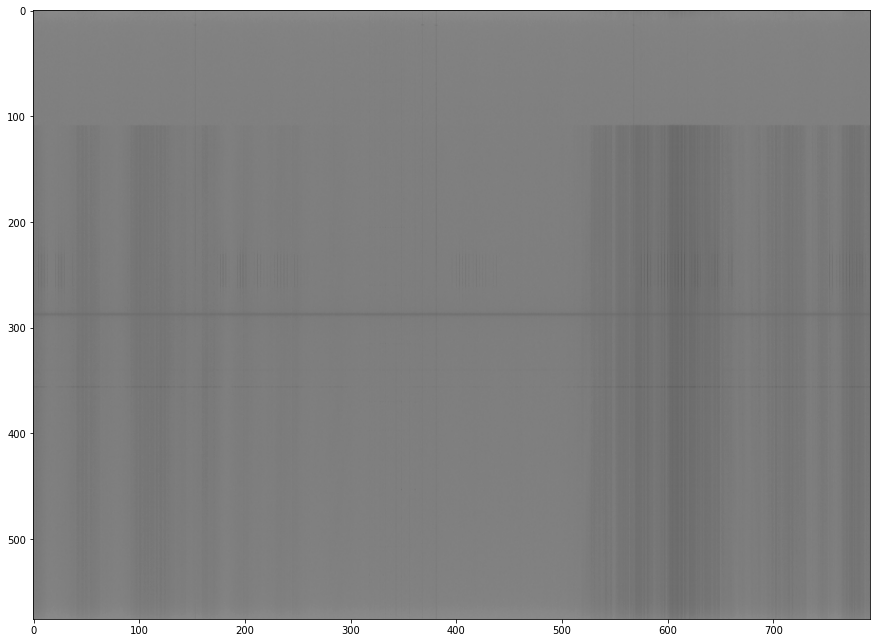

In [5]:
img = mpimg.imread(spec_file_name)

plt.figure(figsize=(15, 12))
imgplot = plt.imshow(img)
plt.show()

### Generate for all files in folder

In [6]:
folder_name = "../../Data/S3/pdx_worker1/"
files = os.listdir(folder_name)
try:
    os.mkdir(folder_name+'Features/')
except:
    print('Adding to Features Folder')

Adding to Features Folder


In [7]:
n_per_seg = 1024 # length of each segment (powers of 2)
win_type = 'hamming' # make ends of each segment match
# t_seg = 0.2 # sample length in seconds

In [8]:
def get_PSD_from_samples(samples, fs, win_type, n_per_seg):
    psd_return = []
    for i, s in enumerate(samples):
        d_real = abs(s)
        fpsd, Pxx_den = signal.welch(d_real, fs, window=win_type, nperseg=n_per_seg)
        psd_return.append(Pxx_den)
    return fpsd, np.array(psd_return) # frequency range should be the same for each sample
        

In [9]:
def save_psd(freqs, psd_array, full_file):
    data_save = {'feat': psd_array, 'freq': freqs}
    
    # construct file name
    date_string = date.today()
    ss = full_file.split('/')
    folder_name = 'Features/PSD_'+str(date_string)
    ss[-1] = folder_name+'/psd_'+ss[-1]
    new_name = '/'.join(ss)
    
    folder_name_full = '/'.join(ss[:-1])
    folder_name_full = folder_name_full+'/'+folder_name

    #     #Save data
    print(new_name)
    try:
        np.save(new_name, data_save)
    except:
        folder_name_full = '/'.join(ss[:-1])
        folder_name_full = folder_name_full+'/'+folder_name
        os.mkdir(folder_name_full)
        np.save(new_name, data_save)

In [10]:
def save_spec_array(Z, extent, full_file):
    data_save = {'feat': Z, 'freq': extent[2:], 'time': extent[:2]}
    
    # construct file name
    date_string = date.today()
    ss = full_file.split('/')
    folder_name = 'Features/SPEC_'+str(date_string)
    ss[-1] = folder_name+'/spec_'+ss[-1]
    new_name = '/'.join(ss)
    
#     #Save data
    print(new_name)
    try:
        np.save(new_name, data_save)
    except:
        folder_name_full = '/'.join(ss[:-1])
        folder_name_full = folder_name_full+'/'+folder_name
        os.mkdir(folder_name_full)
        np.save(new_name, data_save)

In [11]:
for fi in files:
    # SPEC images
    full_file = folder_name+fi
    if os.path.splitext(full_file)[-1] == '.zst':
        samples = read_recording(full_file, sample_rate, sample_dtype, sample_len)
#         spec_file_name = replace_ext(full_file, 'png', all_ext=False)
        
        Z, extent = specgram.specgram(samples, NFFT=n_per_seg, Fs=sample_rate, cmap='Greys', Fc=freq_center, 
                             noverlap=0, skip_fft=0)
        save_spec_array(Z, extent, full_file)
    # IF Saving as an image
    #     specgram.plot_spectrogram(
    #             samples,
    #             spec_file_name,
    #             2048,
    #             sample_rate,
    #             freq_center,
    #             cmap = 'Greys', 
    #             ytics = 20, 
    #             bare = True, 
    #             noverlap = 0,
    #             skip_fft =0 )
    
        samples = read_recording(full_file, sample_rate, sample_dtype, sample_len)
        # PSD
        freqs, psds = get_PSD_from_samples(samples, sample_rate, win_type, n_per_seg)
        save_psd(freqs, psds, full_file)

../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653588935_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653588935_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain70_1653597087_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain70_1653597087_5735000000Hz_20971520sps.s16.zst


/home/kzhou/.pyenv/versions/3.8.2/envs/main/lib/python3.8/site-packages/gamutrf/specgram.py:147: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653589857_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653589857_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653590598_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653590598_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653586663_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653586663_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653589

../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653588089_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653588089_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653591297_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653591297_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653590544_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653590544_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain70_1653597

../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653590758_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653590758_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain70_1653665790_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain70_1653665790_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653589524_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/PSD_2022-06-30/psd_gamutrf_recording_ettus_directional-split_gain45_1653589524_5735000000Hz_20971520sps.s16.zst
../../Data/S3/pdx_worker1/Features/SPEC_2022-06-30/spec_gamutrf_recording_ettus_directional-split_gain45_1653588